In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import skew, kurtosis, shapiro
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


from utils import get_data
price_col = 'd_ln_open_price'
# price_col = 'ln_open_price'

results_df = None

from sklearn.preprocessing import MinMaxScaler

def plot_model(test_data, predictions, p, q, title='Model Estimation'):
    # Normalizing count and d_ln_avg_efficiency
    scaler = MinMaxScaler(feature_range=(-0.15, 0.15))
    normalized_values = scaler.fit_transform(test_data[['count', 'd_ln_avg_efficiency', 'cost', 'open_price']])
    normalized_count = normalized_values[:, 0]
    normalized_d_ln_avg_efficiency = normalized_values[:, 1]
    normalized_cost = normalized_values[:, 2]
    normalized_open_price = normalized_values[:, 3]

    offset = -9 if price_col == 'ln_open_price' else 0
    
    # Plotting the predictions against the actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(test_data.index, test_data[price_col]+offset, label=f'Actual {price_col}', color='blue', marker='o')
    plt.scatter(test_data.index, predictions+offset, label=f'Predicted {price_col}', color='red', marker='x')
    plt.plot(test_data.index, normalized_count, label='Normalized Count', color='green', linestyle='--')
    # plt.plot(test_data.index, normalized_d_ln_avg_efficiency, label='Normalized d_ln_avg_efficiency', color='purple', linestyle='-.')
    plt.plot(test_data.index, normalized_cost, label='Normalized Cost', color='orange', linestyle=':')
    plt.plot(test_data.index, normalized_open_price, label='Normalized Open Price', color='black', linestyle='-.')
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Dashed line at y=0
    plt.title(f'{title} Predictions vs Actual, p={p}, q={q}')
    plt.xlabel('Date')
    plt.ylabel('diff of ln(open price) and Normalized Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.tight_layout()
    plt.show()

def add_constant(train_exog, test_exog):
    # train_exog["const"] = 1
    # test_exog["const"] = 1
    # # Ensure the shapes of train_exog and test_exog match
    # print(train_exog.columns)
    # print(test_exog.columns)
    return train_exog, test_exog

def get_stats(model_fit, predictions, test_data):
    mae = mean_absolute_error(test_data[price_col], predictions)
    mse = mean_squared_error(test_data[price_col], predictions)
    rmse = np.sqrt(mse)
    aic = model_fit.aic
    bic = model_fit.bic
    
    # Test residuals for autocorrelation, normality, and heteroscedasticity
    residuals = model_fit.resid
    # Autocorrelation tests
    ljung_box = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
    durbin_watson = sm.stats.durbin_watson(residuals)
    # Normality tests
    jarque_bera = sm.stats.jarque_bera(residuals)
    shapiro_wilk = shapiro(residuals)
    # Heteroscedasticity test
    white_test = [-1,-1]
    try:
        white_test = sm.stats.het_white(residuals, model_fit.model.exog)
    except Exception as e:
        pass
    
    return {
        'MAE':mae,
        'MSE': mse, 'RMSE': rmse, 'AIC': aic, 'BIC': bic,
        'Ljung-Box': ljung_box['lb_pvalue'].values[0], 'Durbin-Watson': durbin_watson,
        'Jarque-Bera': jarque_bera[1], 'Shapiro-Wilk': shapiro_wilk[1],
        'White Test': white_test[1]
    }

# Adjust the model estimation to use the differenced series
def model_estimation(data, p_range, q_range, title='Model Estimation', eval_size=8):
    global results_df
    
    # Baseline 3: no exog
    # use_exog = False
    use_exog = True

    results = []
    data_size = len(data)
    train_size = data_size - eval_size

    cols = [
        # 'cost',
        # 'cost_squared',
        'd_cost',
        # "d_posts_count", 
        # "d_bitcoin_adoption", 
        # "d_pessimistic_speculation", 
        # "d_optimistic_speculation"
        ]

    for p in p_range:
        for q in q_range:
            try:
                # Perform rolling cross-validation
                rolling_mae = []
                rolling_mse = []
                mean_baseline_mae = []
                mean_baseline_mse = []
                prev_value_baseline_mae = []
                prev_value_baseline_mse = []
                step_size = 1
                summary = ""
                for end in range(train_size, data_size, step_size):  # Adjust these values as needed
                    # print(f"p: {p}, q: {q}, end: {end}")
                    rolling_train = data.iloc[0:end]
                    rolling_test = data.iloc[end:end + step_size]  # Predict one step ahead
                    rolling_train_exog, rolling_test_exog = add_constant(rolling_train[cols], rolling_test[cols])
                    
                    # Baseline 1: Mean Prediction
                    mean_pred = np.mean(rolling_train[price_col])
                    mean_baseline_mae.append(mean_absolute_error(rolling_test[price_col], [mean_pred]*step_size))
                    mean_baseline_mse.append(mean_squared_error(rolling_test[price_col], [mean_pred]*step_size))
                    
                    # Baseline 2: Previous Value Prediction
                    prev_value_pred = rolling_train[price_col].iloc[-1]
                    prev_value_baseline_mae.append(mean_absolute_error(rolling_test[price_col], [prev_value_pred]*step_size))
                    prev_value_baseline_mse.append(mean_squared_error(rolling_test[price_col], [prev_value_pred]*step_size))


                    # ARIMA Model
                    if use_exog:
                        model = ARIMA(rolling_train[price_col], order=(p, 0, q), exog=rolling_train_exog)
                    else:
                        model = ARIMA(rolling_train[price_col], order=(p, 0, q))
                    model_fit = model.fit()
                    
                    summary = model_fit.summary()
                    if use_exog:
                        predictions = model_fit.forecast(steps=step_size, exog=rolling_test_exog)
                    else:
                        predictions = model_fit.forecast(steps=step_size)
                    mae = mean_absolute_error(rolling_test[price_col], predictions)
                    mse = mean_squared_error(rolling_test[price_col], predictions)
                    rolling_mae.append(mae)
                    rolling_mse.append(mse)
                
                # print("rolling_mse")
                # print(rolling_mse)
                avg_mae = np.mean(rolling_mae)
                avg_mse = np.mean(rolling_mse)
                avg_mean_baseline_mae = np.mean(mean_baseline_mae)
                avg_mean_baseline_mse = np.mean(mean_baseline_mse)
                avg_prev_value_baseline_mae = np.mean(prev_value_baseline_mae)
                avg_prev_value_baseline_mse = np.mean(prev_value_baseline_mse)
                results.append({'p': p, 'q': q, 'MAE': avg_mae, 'Mean Baseline MAE': avg_mean_baseline_mae, 'Prev Value Baseline MAE': avg_prev_value_baseline_mae, 'MSE': avg_mse, 'Mean Baseline MSE': avg_mean_baseline_mse, 'Prev Value Baseline MSE': avg_prev_value_baseline_mse,'Summary': summary,})

            except Exception as e:
                print(f"Error with ARIMA({p},0,{q}): {e}")

    # sort results and print/plot only the top 3
    results = sorted(results, key=lambda x: x['MSE'])
    print(f"Mean Baseline MSE: {results[0]['Mean Baseline MSE']}")
    print(f"Previous Value Baseline MSE: {results[0]['Prev Value Baseline MSE']}")
    for i in range(3):
        p = results[i]['p']
        q = results[i]['q']
        
        # Fit the model on the entire training dataset
        train_data = data.iloc[0:train_size]
        test_data = data.iloc[train_size:]
        if use_exog:
            train_exog, test_exog = add_constant(train_data[cols], test_data[cols])
            model = ARIMA(train_data[price_col], order=(p, 0, q), exog=train_exog)
            model_fit = model.fit()
            predictions = model_fit.forecast(steps=len(test_data), exog=test_exog)
        else:
            model = ARIMA(train_data[price_col], order=(p, 0, q))
            model_fit = model.fit()
            predictions = model_fit.forecast(steps=len(test_data))
        print(f"Top {i+1} Model: ARIMA({p},0,{q})")
        print(get_stats(model_fit, predictions, test_data))
        print(results[i]['Summary'])        
        plot_model(test_data, predictions, p, q, title=f"{title} - Top {i+1} Model")



In [12]:

def exploratory_analysis(df):
    # Select only numeric columns for distribution, skewness, and kurtosis
    # numeric_df = df.select_dtypes(include=[np.number])
    cols = [price_col,'cost'] #'d_ln_avg_efficiency', 
    numeric_df = df[cols]
    
    num_cols = len(numeric_df.columns)
    num_rows = (num_cols + 1) // 2  # Ensure enough rows to accommodate all columns
    print("Distribution Plot:")
    numeric_df.hist(bins=20, figsize=(14, num_rows * 3), layout=(num_rows, 2))
    plt.tight_layout()
    plt.show()

    print("Summary Statistics:")
    summary = numeric_df.describe().T
    summary['std'] = numeric_df.std()
    summary['skewness'] = numeric_df.skew()
    summary['kurtosis'] = numeric_df.kurtosis()
    # print(summary)

    for col in cols:
        if col in numeric_df.columns:
            print(f"ACF and PACF Plots for {col}:")
            fig, axes = plt.subplots(1, 2, figsize=(12, 3))
            sm.graphics.tsa.plot_acf(numeric_df[col].dropna(), lags=10, ax=axes[0])
            sm.graphics.tsa.plot_pacf(numeric_df[col].dropna(), lags=10, ax=axes[1])
            plt.show()

    return summary


def check_stationarity(series):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(series.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    # if result[1] > 0.05:
    #     print("Series is not stationary")
    # else:
    #     print("Series is stationary")


from statsmodels.tsa.stattools import coint
def perform_cointegration_test(df, column1, column2):
    """
    Perform the co-integration test on two specified columns of a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - column1: The name of the first column to test.
    - column2: The name of the second column to test.

    Returns:
    - coint_t: The t-statistic of the test.
    - p_value: The p-value of the test.
    - crit_value: Critical values for the test.
    """
    score, p_value, crit_value = coint(df[column1], df[column2])
    print(f"Co-integration test results for {column1} and {column2}:")
    print(f"t-statistic: {score}")
    print(f"p-value: {p_value}")
    print(f"Critical values: {crit_value}")
    if p_value < 0.05:
        print("The series are likely co-integrated.")
    else:
        print("The series are not likely co-integrated.")
    # return score, p_value, crit_value


def cross_correlation(series1, series2, lag=10, plot=True):
    """
    Calculate and plot cross-correlation between two series.
    
    Parameters:
    - series1: First time series.
    - series2: Second time series.
    - lag: Number of lags to calculate cross-correlation for.
    - plot: Whether to plot the cross-correlation values.
    
    Returns:
    - Cross-correlation values.
    """
    cc_values = [series1.corr(series2.shift(l)) for l in range(-lag, lag+1)]
    
    if plot:
        plt.figure(figsize=(10, 5))
        plt.stem(range(-lag, lag+1), cc_values)#, use_line_collection=True)
        plt.xlabel('Lag')
        plt.ylabel('Cross-correlation')
        plt.title('Cross-correlation between series')
        plt.show()
    
    return cc_values

In [13]:
quarterly_data, monthly_data, weekly_data, daily_data = get_data('2015-01-01', '9999-01-01')

In [14]:
quarterly_data.sample(1)

,avg_efficiency,max_efficiency,open_price,optimistic_speculation,pessimistic_speculation,bitcoin_adoption,bitcoin_technology,bitcoin_challenges,altcoins,educational_resources,posts_count,count,cost,time,ln_avg_efficiency,d_ln_avg_efficiency,ln_open_price,d_ln_open_price,d_cost,cost_squared,d_optimistic_speculation,d_pessimistic_speculation,d_bitcoin_adoption,d_posts_count
date,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.013992,0.0339,14754.641461,0.840518,0.357833,0.434239,0.31749,0.51859,0.311706,0.319988,0.127262,0.0,0.351022,119.0,-4.269246,-0.20013,9.599313,0.320622,0.022817,0.123217,0.337027,0.174973,0.046283,0.048683


# Quaterly

Quarterly Data Model Estimation:
Mean Baseline MSE: 0.12155245745179744
Previous Value Baseline MSE: 0.11616527153014557
Top 1 Model: ARIMA(1,0,1)
{'MAE': 0.20963887855805435, 'MSE': 0.07233773110010491, 'RMSE': 0.26895674577913997, 'AIC': 4.257355333023274, 'BIC': 10.918377883899293, 'Ljung-Box': 0.5871553633033209, 'Durbin-Watson': 1.9462651015877326, 'Jarque-Bera': 0.6348783481103671, 'Shapiro-Wilk': 0.5868746638298035, 'White Test': 0.22331584565859547}
                               SARIMAX Results                                
Dep. Variable:        d_ln_open_price   No. Observations:                   35
Model:                 ARIMA(1, 0, 1)   Log Likelihood                   5.241
Date:                Sat, 06 Apr 2024   AIC                             -0.481
Time:                        17:11:53   BIC                              7.296
Sample:                    03-31-2015   HQIC                             2.203
                         - 09-30-2023                           

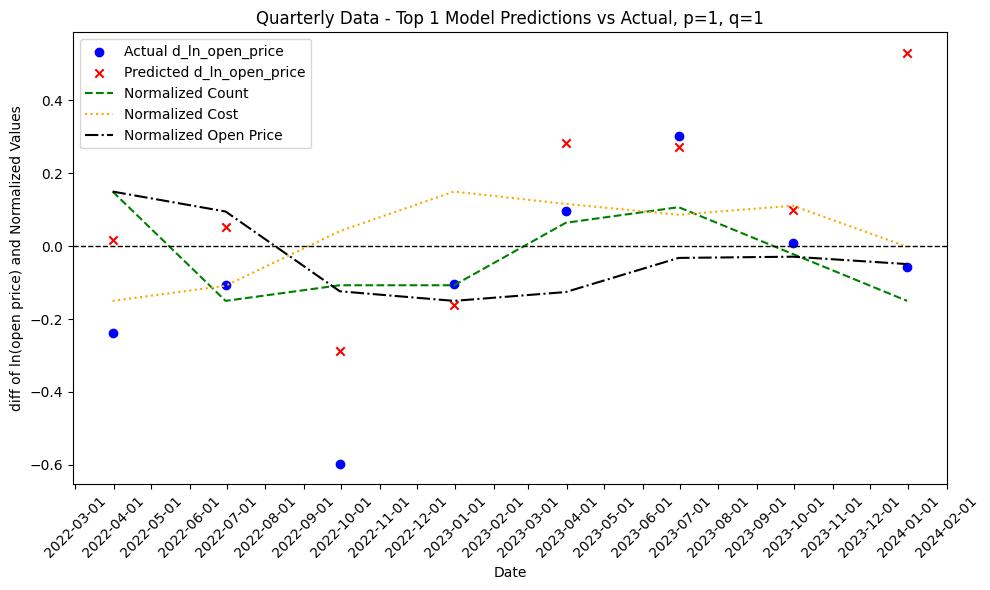

IndexError: list index out of range

In [15]:
print("Quarterly Data Model Estimation:")
# model_estimation(quarterly_data, range(1, 5, 1), range(1, 5, 1), title='Quarterly Data', eval_size=8)
model_estimation(quarterly_data, range(1, 2, 1), range(1, 2, 1), title='Quarterly Data', eval_size=8)
results_df

In [ ]:
print(f"Stationarity check for d_ln_open_price:")
check_stationarity(quarterly_data['d_ln_open_price'])
print(f"\nStationarity check for ln_open_price:")
check_stationarity(quarterly_data['ln_open_price'])
print("\nStationarity check for d_ln_avg_efficiency:")
check_stationarity(quarterly_data['d_ln_avg_efficiency'])
print("\nStationarity check for cost:")
check_stationarity(quarterly_data['cost'])
print("\nStationarity check for d_cost:")
check_stationarity(quarterly_data['d_cost'])

In [ ]:
exploratory_analysis(quarterly_data)

In [ ]:
perform_cointegration_test(quarterly_data, price_col, 'd_ln_avg_efficiency')

In [ ]:
perform_cointegration_test(quarterly_data, price_col, 'd_cost')

In [ ]:
# cross_correlation_values = cross_correlation(quarterly_data['d_ln_avg_efficiency'], quarterly_data[price_col], lag=10)

In [ ]:
cross_correlation_values = cross_correlation(quarterly_data['d_cost'], quarterly_data['d_ln_open_price'], lag=10)

In [ ]:
cross_correlation_values = cross_correlation(quarterly_data['cost'], quarterly_data['ln_open_price'], lag=10)

# Monthly

In [ ]:
print("Monthly Data Model Estimation:")
model_estimation(monthly_data, range(1, 6, 1), range(1, 6, 1), title='Monthly Data', eval_size=12)
results_df

In [ ]:
exploratory_analysis(monthly_data)

# Weekly

In [ ]:
print("Weekly Data Model Estimation:")
model_estimation(weekly_data, range(1, 6, 1), range(1, 6, 1), title='Weekly Data', eval_size=55)
# model_estimation(weekly_data, range(1, 4, 1), range(1, 3, 1), title='Weekly Data', ratio=0.8)
results_df

In [ ]:
exploratory_analysis(weekly_data)

# Daily

In [ ]:
# print("Daily Data Model Estimation:")
# # model_estimation(daily_data, range(1, 6, 1), range(1, 6, 1), title='Daily Data', ratio=0.8)
# model_estimation(daily_data, range(1, 3, 1), range(1, 3, 1), title='Daily Data', ratio=0.8)

In [ ]:
exploratory_analysis(daily_data)